## A Bayesian parameter inference of a **Cascading Hybrid Relativistic Heavy Ion Collision Model**.
>**1. Loading simulation data**
    - This section show how to load simulation data from the disk. Anyone who wish to use the code to do another Bayesian analysis for relativistic heavy ion collision should do minor change to this section that suits their model and simulation data.
            --Python modules used
                - pandas
    
>**2. Preprocessing of the simulation data**
    - We perform a scaling transform and then a Principal Component Analysis (PCA) to reduce the dimensions of the data. We keep only 10 PCs for the next steps of the analysis.
            --Python modules used
                - numpy, sklearn
                
>**3. Load priors and experimental data**
    - We use uniform priors and load the bounds for the priors from a file saved on the disk. Relevant experimental data is also loaded from the disk. A new analysis with new data will have to make changes to this part of the code. 
            --Python modules used
                - pandas

>**4. Building Emulators**
    - Since the simulations are computationally expensive we need surrogate models that can be trained on limited number of points and then used to predict the simulation output at any given point. For this purpose we use Gaussian Processes and they also give the uncertainty in the prediction which is very crucial for the reliability of the Bayesian parameter extraction method. 
            --Python modules used
                - sklearn Gaussian Processors, numpy
                
>**5. Bayesian Parameter Estimation**
    - This is where everything comes together and magic happens! The Bayes theorem is used to find the posterior of the model parameters using the experimental data.
            --Python modules used
                - pandas, numpy, seaborn

In [1]:
name="JETSCAPE_bayes"

In [2]:
#import GPy
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from numpy.linalg import inv
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

import emcee
import ptemcee
import h5py
from scipy.linalg import lapack
from multiprocessing import Pool
from multiprocessing import cpu_count

sns.set("notebook")

### 1. Loading simulation data.

In [3]:
#Saved emulator name
EMU='PbPb2760_emulators_scikit.dat'

In [4]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

In [5]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

In [6]:
# Design points
design = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_design")

In [7]:
#design.head()

In [8]:
#Simulation outputs at the design points
simulation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_simulation")

In [9]:
#simulation.head()

In [10]:
X = design.values
Y = simulation.values

In [11]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 17)
Y.shape : (485, 110)


In [12]:
#Model parameter names in Latex compatble form
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$\\sigma_k$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\tau_R$ [fm/$c$]',
 '$\\alpha$',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$b_{\\pi}$',
 '$T_{\\mathrm{sw}}$ [GeV]']

### 2. Preprocessing of simulation data.

In [13]:
#Scaling the data to be zero mean and unit variance for each feature
SS  =  StandardScaler(copy=True)

In [14]:
#Singular Value decomposition
u, s, vh = np.linalg.svd(SS.fit_transform(Y), full_matrices=True)
print(f'shape of u {u.shape} shape of s {s.shape} shape of vh {vh.shape}')

shape of u (485, 485) shape of s (110,) shape of vh (110, 110)


In [15]:
#whiten and project data to principal component axis (only keeping first 10 PCs)
pc_tf_data=u[:,0:10] * math.sqrt(u.shape[0]-1)
#Scale Transformation from PC space to original data space
inverse_tf_matrix= np.diag(s[0:10]) @ vh[0:10,:] * SS.scale_.reshape(1,110)/ math.sqrt(u.shape[0]-1)

#### A check for consistency of our explicit PCA calculation from scikit-learn library PCA module.
We need access to the scaling transform involved in PCA for uncertainty propagation of emulator predictions. And also it is needed to find the truncation error of keeping only the dominant PC of data. So we prefer to rather use explicit PCA using SVD rather than using the scikit-learn PCA module

##### Check the PC transform

In [16]:
# White actually multiply each PC by sqrt of n_samples-1
pca_analysis = PCA(n_components=10, whiten=True, svd_solver='auto')
pca_analysis.fit(SS.fit_transform(Y))
scikit_pc_tf_data=pca_analysis.transform(SS.fit_transform(Y))
print(f'Transformed data shape {scikit_pc_tf_data.shape}')

Transformed data shape (485, 10)


In [17]:
#The sign difference is OK. That is why we only compare abs value of transformed Data
#explanation https://stackoverflow.com/questions/44765682/in-sklearn-decomposition-pca-why-are-components-negative
print(f'Print True if the transformed data is same from SVD aproach and scikit\
learn PCA methods\n{np.allclose(np.abs(scikit_pc_tf_data),np.abs(pc_tf_data))}')

Print True if the transformed data is same from SVD aproach and scikitlearn PCA methods
True


##### Check inverse PC transform

In [18]:
scikit_inverse_tf_data=SS.inverse_transform(pca_analysis.inverse_transform(scikit_pc_tf_data))
inverse_tf_data=pc_tf_data @ inverse_tf_matrix + np.repeat([SS.mean_],repeats=485, axis=0)
print(f'Print True if the inverse transformed data is same from SVD aproach and scikit\
learn PCA methods\n{np.allclose(scikit_inverse_tf_data,inverse_tf_data)}')

Print True if the inverse transformed data is same from SVD aproach and scikitlearn PCA methods
True


### 3. Load priors and experimental data.

In [19]:
# Bounds for parametrs in the emulator are same as prior ranges so
prior_df = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_prior", index_col=0)

In [20]:
#prior_df.head()

In [21]:
experiment=pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_experiment",index_col=0)
experiment.head()
y_exp=experiment.loc['mean'].values
y_exp_variance=experiment.loc['variance'].values
print(f'Shape of the experiment observables {y_exp.shape} and shape of the experimental error variance{y_exp_variance.shape}')

Shape of the experiment observables (110,) and shape of the experimental error variance(110,)


### 4. Building emulators

In [22]:
design_max=prior_df.loc['max'].values
design_min=prior_df.loc['min'].values

In [23]:
import time
design=X
overide=False
input_dim=len(design_max)
ptp = design_max - design_min
bound=zip(design_min,design_max)
if (os.path.exists(data_path(EMU))) and (overide==False):
    print('Saved emulators exists and overide is prohibited')
    with open(data_path(EMU),"rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators=[]
    for i in range(0,10):
        start_time = time.time()
        kernel=1*krnl.RBF(length_scale=ptp,length_scale_bounds=np.outer(ptp, (4e-1, 1e2)))+ krnl.WhiteKernel(noise_level=.1, noise_level_bounds=(1e-2, 1e2))#+krnl.ConstantKernel()
        GPR=gpr(kernel=kernel,n_restarts_optimizer=4,alpha=0.0000000001)
        GPR.fit(design,pc_tf_data[:,i].reshape(-1,1))
        print(f'GPR score is {GPR.score(design,pc_tf_data[:,i])} \n')
        #print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} \n')
        print("--- %s seconds ---" % (time.time() - start_time))
        Emulators.append(GPR)

if (overide==True) or not(os.path.exists(data_path(EMU))):
    with open(data_path(EMU),"wb") as f:
        pickle.dump(Emulators,f)

Saved emulators exists and overide is prohibited


In [24]:
def predict_observables(model_parameters):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values. Should be an 1D array of 17 model parametrs.
    Return
    ------
    Mean value and full error covaraiance matrix of the prediction is returened. """
    
    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    
    if len(theta)!=17:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,17)
        for i in range(0,10):
            mn,std=Emulators[i].predict(theta,return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean=mean @ inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)
    variance_matrix=np.diag(np.array(variance).flatten())
    A_p=np.abs(inverse_tf_matrix)
    inverse_transformed_variance=np.einsum('ik,kl,lj-> ij', A_p.T, variance_matrix, A_p, optimize=False)
    return inverse_transformed_mean, inverse_transformed_variance

In [25]:
#MAP_params = {'Pb-Pb-2760': [14.128, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136],
#              'Au-Au-200' : [5.821, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136]
#                }

In [26]:
#mm,vv=predict_observables(MAP_params['Pb-Pb-2760'])

### 5. Bayesian parameter inference

In [27]:
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

In [28]:
def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
  #  print(L.diagonal())
    a=np.ones(len(L.diagonal()))*1e-10
    #print(a)
    #print(L)
   # L=L+np.diag(a)
    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

In [29]:
# Covariance truncation error from PC is not yet included
def log_posterior(model_parameters):
    mn,var=predict_observables(model_parameters)
    delta_y=mn-y_exp.reshape(1,-1)
    delta_y=delta_y.flatten()
    
    exp_var=np.diag(y_exp_variance)
    
    total_var=var + exp_var
    #only_diagonal=np.diag(total_var.diagonal())
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)

In [30]:
#log_posterior(MAP_params['Pb-Pb-2760'])

In [31]:
do_mcmc = False

Burn=True
from multiprocessing import Pool
ndim = 17  # number of parameters in the model
nwalkers = 500  # number of MCMC walkers
nburn = 500 # "burn-in" period to let chains stabilize
nsteps =2000  # number of MCMC steps to take
filename = data_path(name+".h5")

if do_mcmc==True:
    backend = emcee.backends.HDFBackend(filename)
    starting_guesses = design_min + (design_max - design_min) * np.random.rand(nwalkers,ndim)
    print(starting_guesses)
    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool, backend=backend)
        print('burn in sampling started')
        if Burn==True:
            backend.reset(nwalkers, ndim)
            print('burn was true going to burnin')
            pos= sampler.run_mcmc(starting_guesses, nburn,progress=True,store = True)
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(np.mean(sampler.acceptance_fraction),nwalkers*nburn))

        print('Burn in completed. Now running the samples')
        sampler.run_mcmc(initial_state=None,nsteps=nsteps,progress=True, tune= False)  
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))
        
        # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
        samples = backend.get_chain(flat=True,discard=nburn)
        samples_df=pd.DataFrame(samples, columns=model_param_dsgn)
else:
    df1=h5py.File(filename,mode='r')
    samples= df1['mcmc']['chain'][500:,:,:]
    samples_df=pd.DataFrame(samples.reshape(-1,17), columns=model_param_dsgn)

In [32]:
samples_df.head()

,$N$[$2.76$TeV],$p$,$\sigma_k$,$w$ [fm],$d_{\mathrm{min}}$ [fm],$\tau_R$ [fm/$c$],$\alpha$,"$T_{\eta,\mathrm{kink}}$ [GeV]","$a_{\eta,\mathrm{low}}$ [GeV${}^{-1}$]","$a_{\eta,\mathrm{high}}$ [GeV${}^{-1}$]",$(\eta/s)_{\mathrm{kink}}$,$(\zeta/s)_{\max}$,"$T_{\zeta,c}$ [GeV]",$w_{\zeta}$ [GeV],$\lambda_{\zeta}$,$b_{\pi}$,$T_{\mathrm{sw}}$ [GeV]
0,10.883019,0.155443,0.953387,1.320491,3.212816,1.849612,0.048524,0.146820,-0.972577,0.163016,0.091675,0.191249,0.214075,0.119791,0.437023,7.204627,0.133219
1,16.727336,-0.084966,1.236814,0.882537,3.041271,0.709009,0.248369,0.203307,0.991861,-0.868808,0.187344,0.073616,0.217871,0.086949,-0.782404,4.045305,0.140441
2,13.284484,0.071946,0.971914,1.032055,0.874248,1.596539,-0.002285,0.168353,0.012968,0.274359,0.138411,0.085414,0.154520,0.137593,0.029835,5.168139,0.134497
3,13.574669,0.029460,1.083337,1.035231,3.342812,1.519719,0.082261,0.189270,-0.173206,-0.110443,0.143305,0.101834,0.130463,0.120505,-0.300533,4.614710,0.133467
4,13.549534,-0.001446,0.944184,1.182966,0.364143,1.653465,0.055445,0.195895,-1.640059,1.095958,0.066359,0.094140,0.159239,0.148375,0.062888,3.304126,0.132028


#### Find MAP

In [33]:
find_map_param = False
if find_map_param == True:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    rslt = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                           bounds=bounds,
                                          disp=True,
                                          tol=1e-7,
                                         )
    print(rslt.x)

In [34]:
map_values_saved = np.array([14.0139395 ,  0.01907986,  0.99684969,  1.00082965,  1.265258  ,
        1.4427919 ,  0.06691838,  0.23605955, -0.12761594,  0.01850112,
        0.12516493,  0.11635104,  0.18826292,  0.10610828,  0.08978906,
        5.60047767,  0.13516286])

In [35]:
#np.divide(map_values_saved,MAP_params['Pb-Pb-2760'])

In [36]:
sns.color_palette('bright')

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

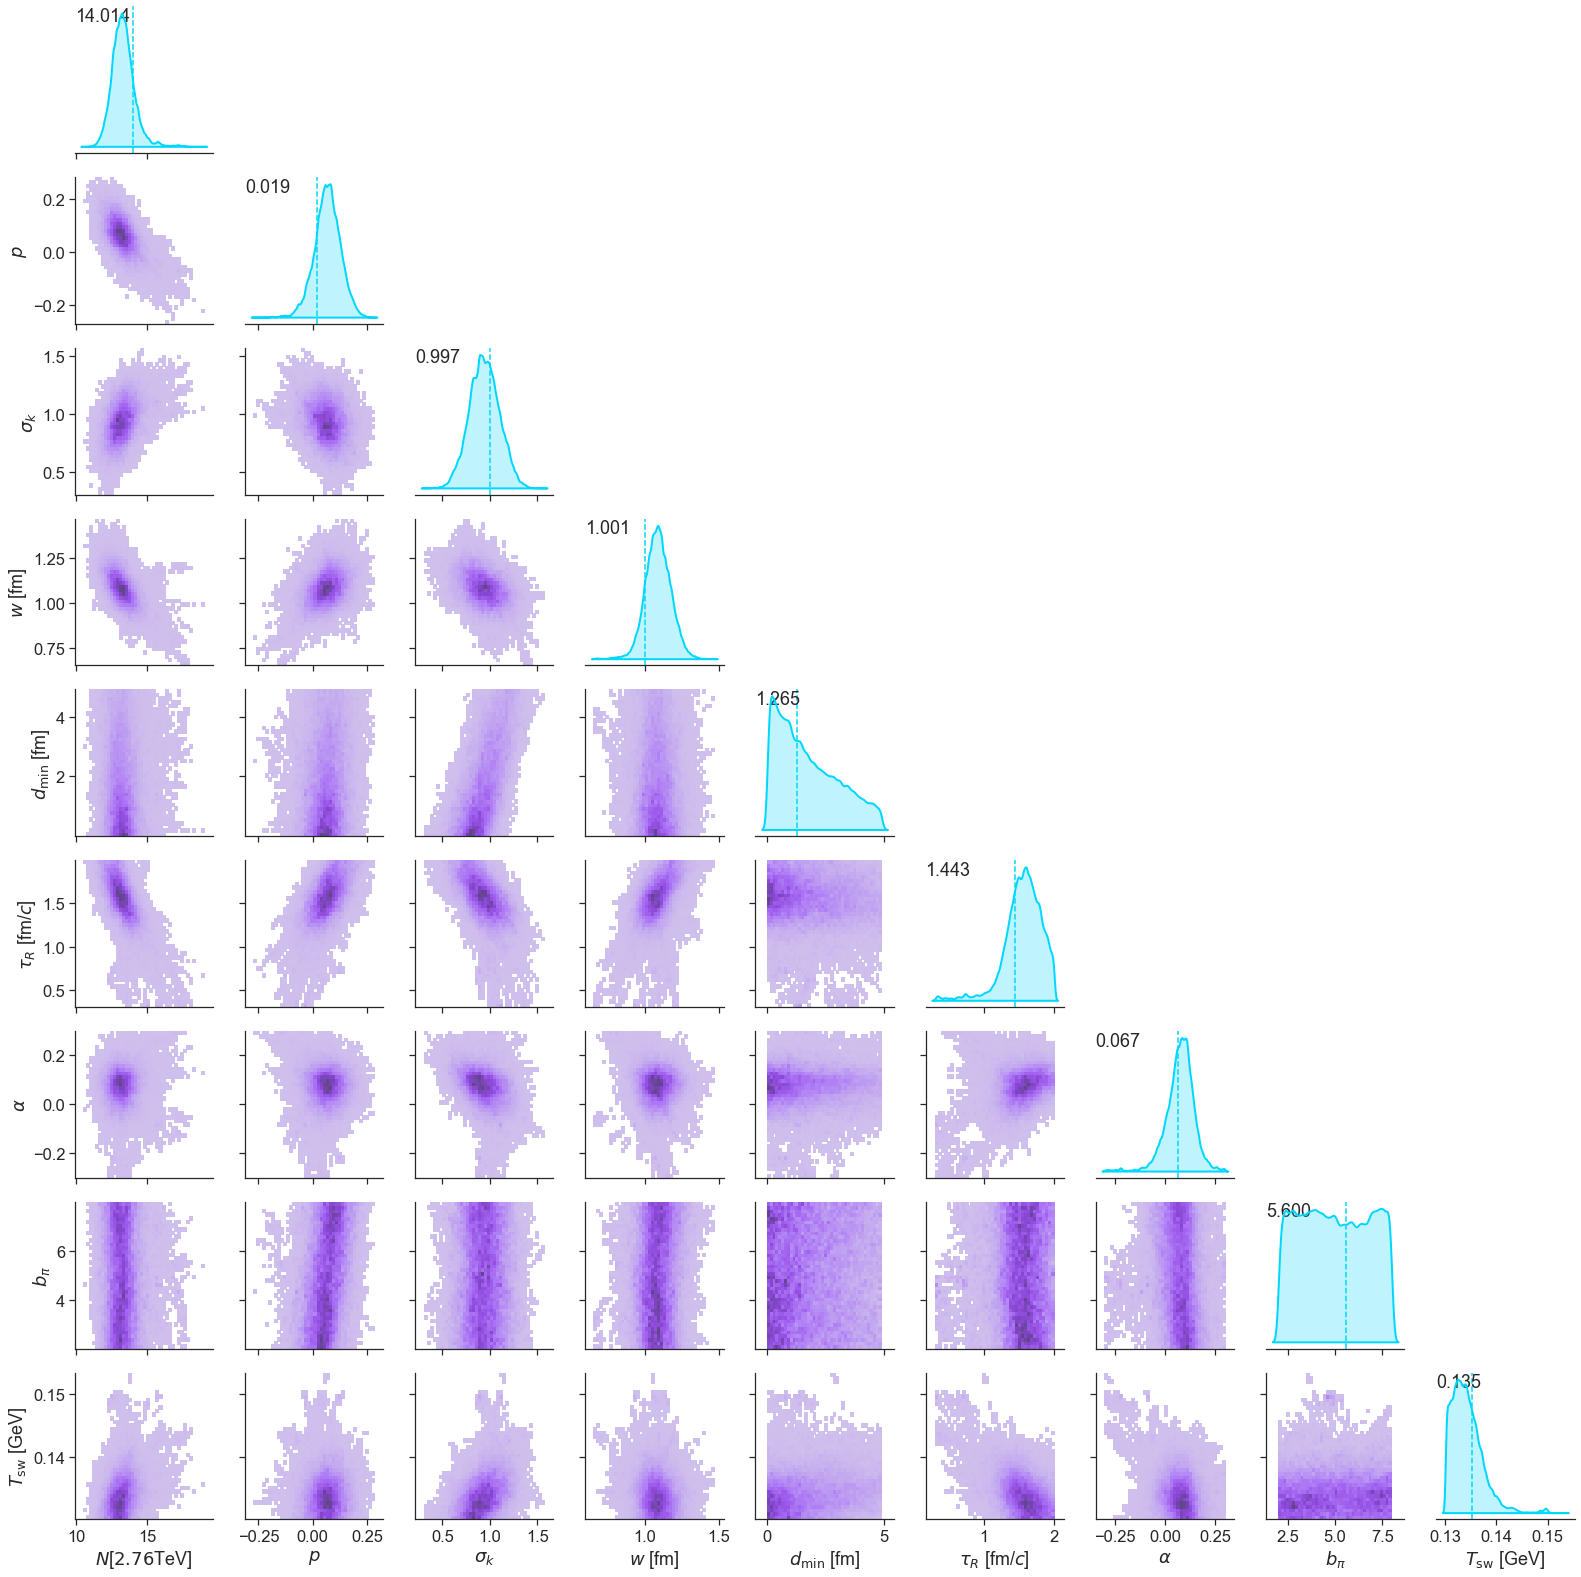

<Figure size 432x288 with 0 Axes>

In [37]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")
map_parameters=map_values_saved.flatten()
sns.set_palette('bright')
observables_to_plot=[0, 1, 2 ,3 , 4, 5, 6, 15, 16]
g = sns.PairGrid(samples_df.iloc[:,observables_to_plot], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=40, color=sns.color_palette()[4])
#g.map_upper(sns.kdeplot, shade=True, color=sns.color_palette()[0])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[9])
for n,i in enumerate(observables_to_plot):
    ax=g.axes[n][n]
    ax.axvline(x=map_parameters[i], ls='--', c=sns.color_palette()[9])
    ax.text(0,0.9,s= f'{map_parameters[i]:.3f}', transform=ax.transAxes)
plt.show()
plt.tight_layout()
save_fig(name+"partial")

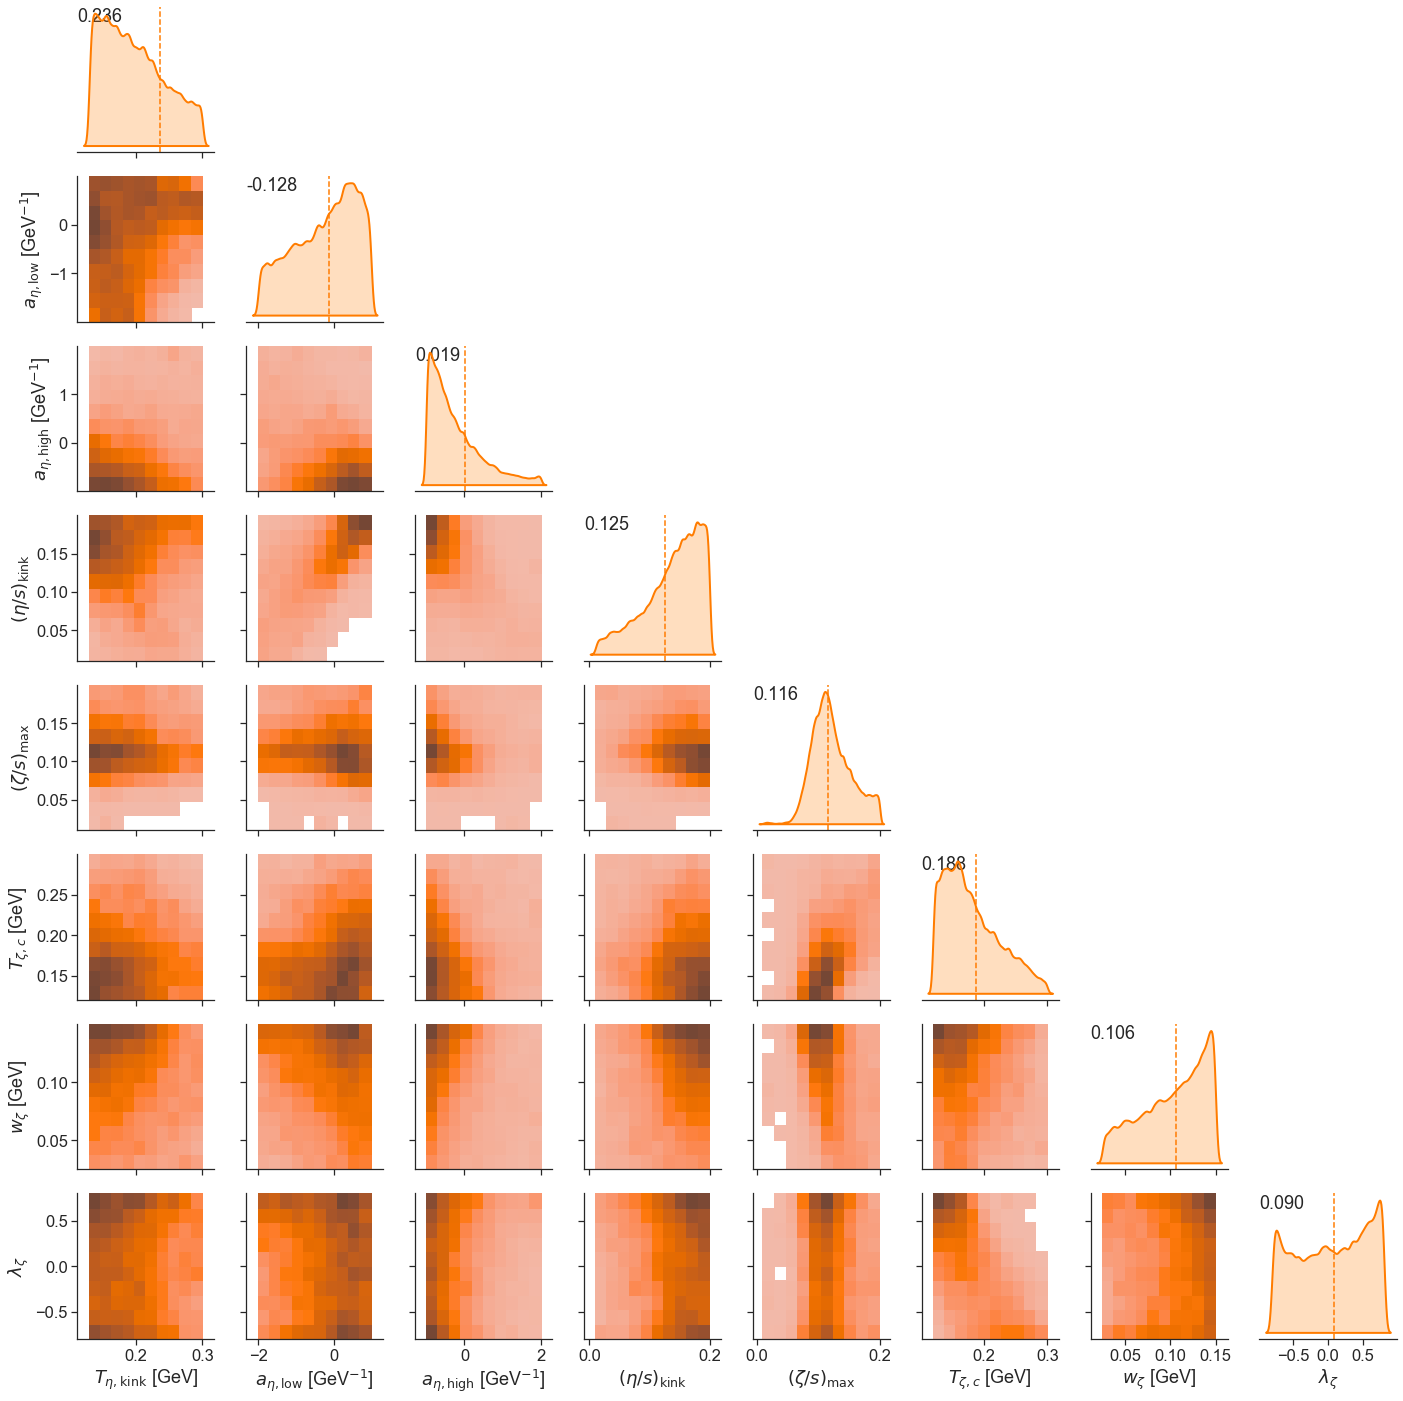

<Figure size 432x288 with 0 Axes>

In [38]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")
map_parameters=map_values_saved.flatten()
sns.set_palette('bright')
observables_to_plot=[7, 8 , 9, 10, 11, 12, 13, 14]
g = sns.PairGrid(samples_df.iloc[:,observables_to_plot], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=10, color=sns.color_palette()[5])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[1])
for n,i in enumerate(observables_to_plot):
    ax=g.axes[n][n]
    ax.axvline(x=map_parameters[i], ls='--', c=sns.color_palette()[1])
    ax.text(0,0.9,s= f'{map_parameters[i]:.3f}', transform=ax.transAxes)
plt.show()
plt.tight_layout()
save_fig(name+"viscous")

#### Define temperature dependent viscosity functions

In [39]:
def zeta_over_s(T, zmax, T0, width, asym):
    DeltaT = T - T0
    sign = 1 if DeltaT>0 else -1
    x = DeltaT/(width*(1.+asym*sign))
    return zmax/(1.+x**2)
zeta_over_s = np.vectorize(zeta_over_s)

def eta_over_s(T, T_k, alow, ahigh, etas_k):
    if T < T_k:
        y = etas_k + alow*(T-T_k)
    else:
        y = etas_k + ahigh*(T-T_k)
    if y > 0:
        return y
    else:
        return 0.
eta_over_s = np.vectorize(eta_over_s)

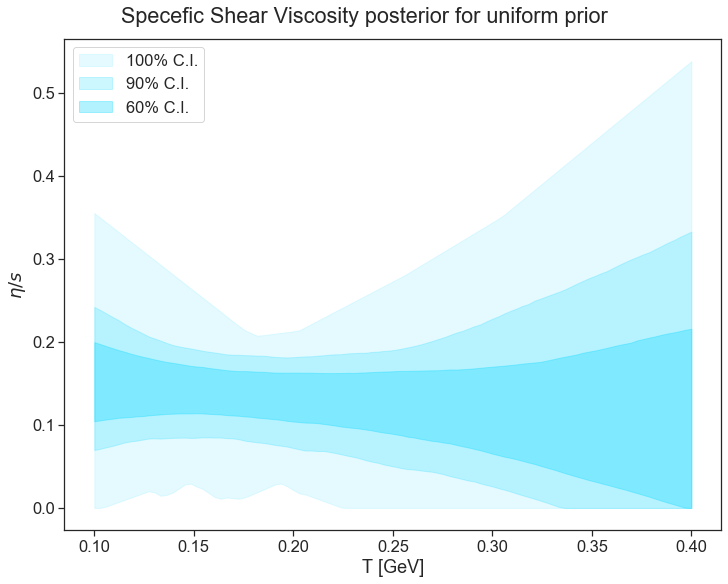

In [46]:
Tt = np.linspace(0.1, 0.4, 100)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Specefic Shear Viscosity posterior for uniform prior", wrap=True)

#n_samples_prior = 100000
prune = 1
prior_etas = []
    
for row in samples_df.iloc[0:100000,[7,8,9,10]].values:
    [T_k, alow, ahigh, etas_k] = row
    prior=[]
    for T in Tt:
        prior.append(eta_over_s(T,T_k,alow,ahigh,etas_k))
    prior_etas.append(prior)
per0,per5,per20,per80,per95,per100=np.percentile(prior_etas,[0,5,20,80,95,100], axis=0)
axes.fill_between(Tt, per0,per100,color=sns.color_palette()[9], alpha=0.1, label='100% C.I.')
axes.fill_between(Tt,per5,per95,color=sns.color_palette()[9], alpha=0.2, label='90% C.I.')
axes.fill_between(Tt,per20,per80, color=sns.color_palette()[9], alpha=0.3, label='60% C.I.')
pos=np.array(prior_etas).T
#axes.violinplot(pos[1::10,:].T, positions=Tt[1::10],widths=0.03)

axes.legend(loc='upper left')
#axes.set_ylim(0,1.2)
axes.set_xlabel('T [GeV]')
axes.set_ylabel('$\eta/s$')
save_fig('shear_pos_uniform_prior')

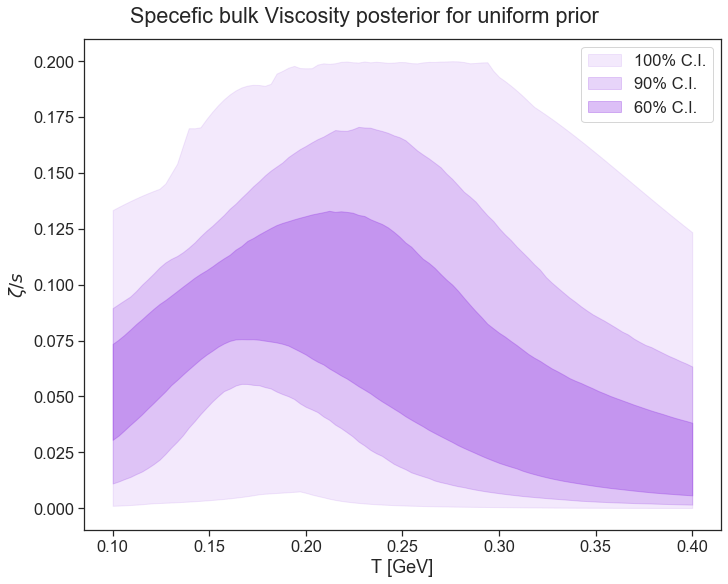

In [47]:
Tt = np.linspace(0.1, 0.4, 100)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Specefic bulk Viscosity posterior for uniform prior", wrap=True)

prune = 1
prior_zetas = []
    
for row in samples_df.iloc[0:100000,[11,12,13,14]].values:
    [zmax, T0, width, asym] = row   
    prior=[]
    for T in Tt:
        prior.append(zeta_over_s(T,zmax, T0, width, asym))
    prior_zetas.append(prior)
per0,per5,per20,per80,per95,per100=np.percentile(prior_zetas,[0,5,20,80,95,100], axis=0)
axes.fill_between(Tt, per0,per100,color=sns.color_palette()[4], alpha=0.1, label='100% C.I.')
axes.fill_between(Tt,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
axes.fill_between(Tt,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
pos=np.array(prior_zetas).T
#axes.violinplot(pos[1::10,:].T, positions=Tt[1::10],widths=0.03)

axes.legend(loc='upper right')
#axes.set_ylim(0,1.2)
axes.set_xlabel('T [GeV]')
axes.set_ylabel('$\zeta/s$')
save_fig('bulk_pos_uniform_prior')

# To do list
> Emulator validation

> Closure tests

> Observable predictions from MAP

> Including other systems in the parameter estimation

> Tests for MCMC convergence

> Bayesian evidence calculation

> Repeat the Analysis for different model choices

> Bayesian Model Averaging
